In [1]:
import cv2
import matplotlib.pyplot as plt
from os.path import isfile
import torch.nn.init as init
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import os
from PIL import Image, ImageFilter
#print(os.listdir("../input"))
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam, SGD, RMSprop
import time
from torch.autograd import Variable
import torch.functional as F
from tqdm import tqdm
from sklearn import metrics
import urllib
import pickle
import cv2
import torch.nn.functional as F
from torchvision import models
#import seaborn as sns
import random
from apex import amp
import sys

In [2]:
from efficientnet_pytorch import EfficientNet
from functools import partial
import scipy as sp

In [3]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return cohen_kappa_score(np.round(y_hat), y, weights='quadratic')

In [4]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [6]:
os.mkdir('final')

FileExistsError: [Errno 17] File exists: 'final'

In [7]:
# weight_decay = 1e-5
# lr          = 1e-4
weight_decay = 2e-5
lr          = 5e-5

# weight_decay = 1e-4
# lr          = 1e-5

In [8]:
num_classes = 1
seed_everything(1234)
# lr          = 1e-6
efficientnet_arch = 'efficientnet-b4'
IMG_SIZE    = EfficientNet.get_image_size(efficientnet_arch)

In [10]:
IMG_SIZE

380

In [11]:
train_batch = 32
val_batch = 128

In [12]:
train      = '/data/kaggle/aptos/train/images/'
train_2015      = '/data/kaggle/aptos/trainold/resized_train_cropped/'
#valid      = '/data/aptos/train/images/'
test       = '/data/kaggle/aptos/test/images/'

# train_csv  = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')

### train_csv = pd.read_csv("/data/aptos/train.csv")
#train_csv = pd.read_csv("/data/aptos/trainboth.csv")
#valdata = pd.read_csv("/data/aptos/valboth.csv")
test_df = pd.read_csv("/data/kaggle/aptos/test.csv")

In [13]:
# this is the starting checkpoint
# these weights come from pre-training on an equal mix of old and new data
minfile = 'gray_all_b4_fixed_lr_1e-4_380.pt'

In [14]:
# how often do we eval our model?
eval_steps = 55
# how often do we print the loss?
print_steps=5

In [15]:
# the training dataset
train_df_1 = pd.read_csv("/data/kaggle/aptos/newtrainh.csv")

# the validation dataset
val_df_1 = pd.read_csv("/data/kaggle/aptos/newvalh.csv")

# uncomment this to train on both
# both = []
# both.append(train_df_1)
# both.append(val_df_1)
# train_df = pd.concat(both)
# val_df = pd.concat(both)

# comment this out if you want to train on both
train_df = train_df_1
val_df = val_df_1



train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [16]:
train_df.head()

,id_code,diagnosis
0,f72ef9ceeaa8,1
1,de18071c36e6,0
2,248dec89b3a2,0
3,36041171f441,1
4,7a238a1d3cf3,4


In [17]:
val_df.head()

,id_code,diagnosis
0,2974c6ad1d58,0
1,1d29cb2f4296,0
2,6e092b306fe1,2
3,8a01daa423f7,1
4,a963ac561580,0


In [ ]:
# test_df.reset_index(drop=True, inplace=True)
# test_df.head()

In [18]:
def expand_path(p):
    p = str(p)
    if isfile(train + p + ".png"):
        return train + (p + ".png")
    if isfile(train_2015 + p + '.jpeg'):
        return train_2015 + (p + ".jpeg")
    if isfile(test + p + ".png"):
        return test + (p + ".png")
    return p

def p_show(imgs, label_name=None, per_row=3):
    n = len(imgs)
    rows = (n + per_row - 1)//per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(15,15))
    for ax in axes.flatten(): ax.axis('off')
    for i,(p, ax) in enumerate(zip(imgs, axes.flatten())): 
        img = Image.open(expand_path(p))
        ax.imshow(img)
        ax.set_title(train_df[train_df.id_code == p].diagnosis.values)

/opt/conda/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


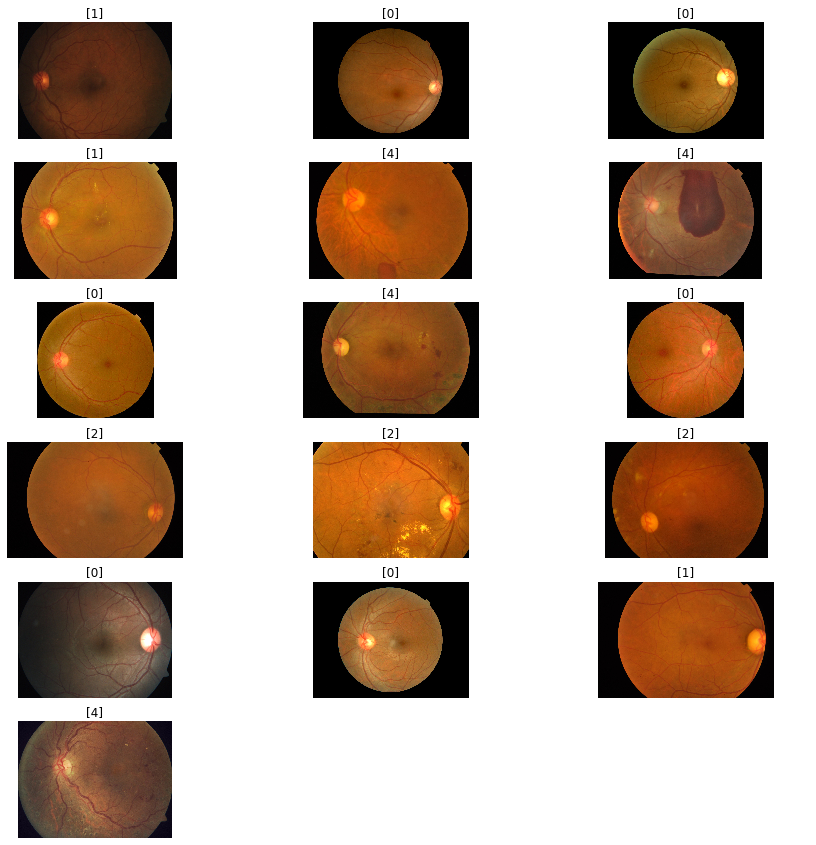

In [19]:
imgs = []
for p in train_df.id_code:
     imgs.append(p)
     if len(imgs) == 16: break
p_show(imgs)

In [20]:
#The Code from: https://www.kaggle.com/ratthachat/aptos-updated-albumentation-meets-grad-cam

def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [21]:
class MyDataset(Dataset):
    
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        label = self.df.diagnosis.values[idx]
        label = np.expand_dims(label, -1)
        
        p = self.df.id_code.values[idx]
        p_path = expand_path(p)
        image = cv2.imread(p_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_image_from_gray(image)
        try: 
          image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        except:
            print("unable to resize image: ", p_path)
#        image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)
        image = transforms.ToPILImage()(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [22]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-120, 120)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [23]:
val_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-120, 120)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [24]:
trainset     = MyDataset(train_df, transform =train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch, shuffle=True, num_workers=12)
#valset       = MyDataset(val_df, transform   =train_transform)
valset       = MyDataset(val_df, transform   =val_transform)
val_loader   = torch.utils.data.DataLoader(valset, batch_size=val_batch, shuffle=False, num_workers=12)

In [ ]:
#testset       = MyDataset(test_df, transform   =val_transform)
#test_loader   = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=12)

In [25]:
#model = EfficientNet.from_name('efficientnet-b0')
# model = EfficientNet.from_name('efficientnet-b3')
model = EfficientNet.from_name('efficientnet-b4')
# model.load_state_dict(torch.load('/data/models/efficientnet/efficientnet-b3-5fb5a3c3.pth'))
#minfile = '/data/models/efficientnet/efficientnet-b3-5fb5a3c3.pth'
#minfile = 'nogray_all_b3.pt'

# model.load_state_dict(torch.load(minfile))
finetune = True
# model.load_state_dict(torch.load('../input/efficientnet-pytorch/efficientnet-b0-08094119.pth'))
#model.load_state_dict(torch.load('/data/models/efficientnet/efficientnet-b0-08094119.pth'))
#model.load_state_dict(torch.load('/data/models/efficientnet/efficientnet-b5-586e6cc6.pth'))
# model.load_state_dict(torch.load('/data/models/efficientnet/efficientnet-b4-e116e8b3.pth'))

if not finetune:
  model.load_state_dict(torch.load(minfile))
  in_features = model._fc.in_features
  model._fc = nn.Linear(in_features, num_classes)
else:
  in_features = model._fc.in_features
  model._fc = nn.Linear(in_features, num_classes)
  model.load_state_dict(torch.load(minfile)) 
model.cuda()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.MSELoss()
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)

In [27]:
def train_model(epoch):
    model.train() 
        
    avg_loss = 0.
    sum_loss = 0.
    print_steps_loss_beg= 0
    optimizer.zero_grad()
    start_time   = time.time()
    for idx, (imgs, labels) in enumerate(train_loader):

        if idx > 0 and idx % print_steps == 0:

            time_per_step   = (time.time() - start_time) / eval_steps
            aloss = (sum_loss-print_steps_loss_beg) / print_steps
            print('epoch {}, step {}/{}, time/step {:.2f}, loss {:.4f}'.format(epoch, idx, len(train_loader), time_per_step, aloss, TTA))
            start_time   = time.time()  
            print_steps_loss_beg = sum_loss
        
        if idx % eval_steps == 0:
            print('step {}, running eval with tta {}'.format(idx, TTA))
            estart_time   = time.time()
#            avg_val_loss1, qk1, coeffs1 = test_model1(val_df1, val_loader1a, model, TTA=TTA)
#            avg_val_loss2, qk2, coeffs2 = test_model1(val_df2, val_loader2a, model, TTA=TTA)

            avg_val_loss, qk, coeffs = test_model(val_df, val_loader, model, TTA=TTA)
    
            etime   = (time.time() - estart_time)
            print('lr {:.6f}, vloss {:.4f}, qk {:.4f}, time {:.2f}'.format(lr, avg_val_loss, qk, etime))
            print(*coeffs, sep = ", ") 
#            print(*coeffs2, sep = ", ")
            start_time   = time.time()
            
            mfiled = mfile_base + str(epoch) + "_" + str(idx) + '.pt'
            torch.save(model.state_dict(), mfiled)
            print('saved model ' + mfiled)
            
            model.train()        
        
        imgs_train, labels_train = imgs.cuda(), labels.float().cuda()
        output_train = model(imgs_train)
        loss = criterion(output_train,labels_train)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step() 
        optimizer.zero_grad() 
        sum_loss += loss.item()
        avg_loss += loss.item() / len(train_loader)


        
    return avg_loss

In [28]:
def test_model(val_df, val_loader, model, TTA=1):
    
    test_pred = np.zeros((len(val_df), 1))
#    print("len val loader: ", len(val_loader))
    
    avg_val_loss = 0.
    model.eval()
    
    for _ in range(TTA):
      with torch.no_grad():
        for idx, (imgs, labels) in enumerate(val_loader):
#            print("idx:", idx)
            imgs_vaild, labels_vaild = imgs.cuda(), labels.float().cuda()
            output = model(imgs_vaild)
            avg_val_loss += criterion(output, labels_vaild).item() / len(val_loader) 
#            outputlist.append(output_test)
            o = output.detach().cpu().squeeze().numpy().reshape(-1, 1)
            test_pred[idx*val_batch:(idx + 1)*val_batch] += o
    
    test_pred = test_pred / TTA   
    avg_val_loss = avg_val_loss / TTA
    outputlist=test_pred.tolist() 
    
    targets = val_df['diagnosis']
    optR = OptimizedRounder()
    optR.fit(outputlist, targets)
    coeffs = optR.coefficients()
#    print(coefficients)
    valid_predictions = optR.predict(outputlist, coeffs)
#    valid_predictions
    qk = quadratic_kappa(valid_predictions, targets)
    
    return avg_val_loss, qk, coeffs

In [29]:
mfile_base = 'b4_finetune_class'
TTA=5

In [ ]:
avg_val_loss, qk, coeffs = test_model(val_df, val_loader, model, TTA=5)
print('vloss {:.4f}, qk {:.4f}'.format(avg_val_loss, qk))
print(*coeffs, sep = ", ") 

In [ ]:
## best_avg_loss = 100.0
n_epochs      = 2

for epoch in range(n_epochs):
    print('lr:', lr) 
#    print('lr:', scheduler.get_lr()[0]) 
    start_time   = time.time()
    avg_loss     = train_model(epoch)
#    avg_val_loss = test_model()
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss, elapsed_time))
